<a href="https://colab.research.google.com/github/mainaroseline/Mobile-Phone-Sentiment-Analysis/blob/main/Mobile_Phone_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Business Understanding

## 1.1. Problem Statement

Purchasing a product is an interaction between two entities, consumers and business owners. Consumers often use reviews to make decisions about what products to buy, while businesses, on the other hand, not only want to sell their products but also want to receive feedback in terms of consumer reviews. Consumer reviews about purchased products shared on the internet have a great impact. Human nature is generally structured to make decisions based on analyzing and getting the benefit of other consumer experience and opinions because others often have a great influence on our beliefs, behaviors, perception of reality, and the choices we make. Hence, we ask others for their feedback whenever we are deciding on doing something. Additionally, this fact applies not only to consumers but also to organizations and institutions.

As social media networks have evolved, so have the ways that consumers express their opinions and feelings. With the vast amount of data now available online, it has become a challenge to extract useful information from it all. Sentiment analysis has emerged as a way to predict the polarity (positive, negative, or neutral) of consumer opinion, which can help consumers better understand the textual data.

E-commerce websites have increased in popularity to the point where consumers rely on them for buying and selling. These websites give consumers the ability to write comments about different products and services, which has resulted in a huge amount of reviews becoming available. Consequently, the need to analyze these reviews to understand consumers’ feedback has increased for both vendors and consumers. However, it is difficult to read all the feedback for a particular item, especially for popular items with many comments. 

In this research, we attempt to build a predictor for consumers’ satisfaction on mobile phone products based on the reviews. We will also attempt to understand the factors that contribute to classifying reviews as positive, negative or neutral (based on important or most frequent words). This is believed to help companies improve their products and also help potential buyers make better decisions when buying products.


### 1.1.1. Main objective

- To perform a sentiment analysis of mobile phone reviews from Amazon website to determine how these reviews help consumers to have conﬁdence that they have made the right decision about their purchases.

### 1.1.2. Specific Objectives

- To help companies understand their consumers’ feedback to maintain their products/services or enhance them.
- To provide insights to companies in curating offers on speciﬁc products to increase their proﬁts and customer satisfaction.
- To understand the factors that contribute to classifying reviews as positive, negative or neutral (based on important or most frequent words).
- To determine mobile phones key features that influence smartphone purchases.
- To perform a market segmentation of consumers based on their reviews
- To advise the advertisement department in companies on these key features to use as selling points and to specific customer segments  in upcoming advertisements.

### 1.1.3. Metrics of Success

The best performing model will be selected based on:
- An accuracy score > 80%
- An F1 score > 0.85 


# 2. Data Understanding

The data used for this project was scraped from [amazon.com](https://www.amazon.com/), an ecommerce platform that sells different products. It contains more than 17 thousand reviews  of unlocked mobile phones sold on between the period 2020 to August 2022. The data has 7 features:

- Rating  -  Contains the rating awarded to a product.                   
- Review Title  - The title of review of a product.
- Review - Contains the review of a product.
- Location and Date of Review - The date and location from where a review was done.
- Affiliated Company  -  Company affiliated with the mobile phone.
- Brand and Features  - The brand of the product and its relevant features.
- Price - The price of the product.




# 3. Loading Relevant Libraries & Data

## 3.1. Loading Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
# # All the relevant downloads and pip installs


# !pip install contractions
# !pip install transformers
# # !pip install nltk
# # !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

# # import nltk
# # nltk.download('stopwords')
# # nltk.download('vader_lexicon')
# # nltk.download('all', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('punkt', quiet=True)
# nltk.download('omw-1.4')
# # nltk.download('stopwords', quiet=True)
# # nltk.download('tagsets', quiet=True)
# nltk.download('averaged_perceptron_tagger', quiet=True)


In [5]:
# Importing relevant libraries

import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import softmax

import torch
import contractions
from wordcloud import WordCloud, STOPWORDS


import re
import nltk
import string
from nltk import pos_tag
from textblob import TextBlob
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, word_tokenize



from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## 3.2. Loading Data

In [6]:
# loading the data

df = pd.read_csv('/content/drive/Shareddrives/Alpha/Data/Amazon Combined Data.csv')

# previewing the data

df.head()

,Rating,Review Title,Review,Location and Date of Review,Affiliated Company,Brand and Features,Price
0,4.0 out of 5 stars,"\n.. not what ordered, not New... but it works...","\nSo first off...it's not what I ordered, but ...","Reviewed in the United States on February 11, ...",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
1,3.0 out of 5 stars,\nNot for Cricket Wireless and this two review...,"\nThe phone itself is a okay android device, b...","Reviewed in the United States on February 4, 2021",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
2,3.0 out of 5 stars,\nWill not work on T-Mobile sysem!\n,\nNew phone write up indicates T-Mobile system...,"Reviewed in the United States on June 7, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
3,3.0 out of 5 stars,\nA burner or for a kid\n,\nI use this as a burner w/o a sim card in it....,"Reviewed in the United States on April 14, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
4,4.0 out of 5 stars,\nIt works okay\n,\nIt works fine\n,"Reviewed in the United States on August 13, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99


## 3.3. Previewing Data

In [7]:
# checking the shape of the data

print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')

The data has 17198 rows and 7 columns


In [8]:
# checking the data types of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17198 entries, 0 to 17197
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Rating                       17198 non-null  object
 1   Review Title                 17198 non-null  object
 2   Review                       17168 non-null  object
 3   Location and Date of Review  17198 non-null  object
 4   Affiliated Company           17198 non-null  object
 5   Brand and Features           17198 non-null  object
 6   Price                        17198 non-null  object
dtypes: object(7)
memory usage: 940.6+ KB


# 4. Data Cleaning

## 4.1. Missing values
- Checking for missing values


In [9]:
# Define a function to get missing data

def missing_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    The function finds columns that have missing values, and returns the column,
    and the number of rows with missing data
    """
    missing_data = data.isna().sum()

    missing_data = missing_data[missing_data>0]

    return missing_data

In [10]:
# Getting the sum of missing values per column

missing_data(df).to_frame()

,0
Review,30


Out of the 7 columns, only the review's column has missing values.

Since the dataset is large, the missing values can be dropped and still retain relevant information.

In [11]:
# Dropping the missing values

df.dropna(inplace = True)

# Confirming there are no missing values 

print('The data has {} missing values'.format(df['Review'].isna().sum()))

The data has 0 missing values


## 4.2. Duplicates

In [12]:
# Checking for duplicates

print(f"The data has {df.duplicated().sum()} duplicated rows")

The data has 6595 duplicated rows


In [13]:
# Exploring the duplicates

duplicates = df[df.duplicated()]

duplicates.head(4)

,Rating,Review Title,Review,Location and Date of Review,Affiliated Company,Brand and Features,Price
30,4.0 out of 5 stars,"\n.. not what ordered, not New... but it works...","\nSo first off...it's not what I ordered, but ...","Reviewed in the United States on February 11, ...",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
31,3.0 out of 5 stars,\nNot for Cricket Wireless and this two review...,"\nThe phone itself is a okay android device, b...","Reviewed in the United States on February 4, 2021",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
32,3.0 out of 5 stars,\nWill not work on T-Mobile sysem!\n,\nNew phone write up indicates T-Mobile system...,"Reviewed in the United States on June 7, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99
33,3.0 out of 5 stars,\nA burner or for a kid\n,\nI use this as a burner w/o a sim card in it....,"Reviewed in the United States on April 14, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",$69.99


Duplicated columns will be dropped to avoid it misguiding our analysis and prediction process.

In [14]:
# Dropping the duplicates

df.drop_duplicates(inplace = True)


In [15]:
# Confirming if there are duplicates

print(f"The data has {df.duplicated().sum()} duplicated rows")

The data has 0 duplicated rows


## 4.3. Cleaning Specific Columns

### 4.3.1. Rating Column

For better analysis the rating value needs to be extracted and in cast as an integer.

In [16]:
#Extracting the digits in the Rating column and converting it to an interger type

df["Rating"] = df["Rating"].str.extract('(\d+)').astype(int)

# previewing the data

df["Rating"].head(3).to_frame()

,Rating
0,4
1,3
2,3


### 4.3.2. Price Column

The price columns seems has a dollar sign which could affect analysis. It needs stripping and conversion to int/float

In [17]:
#Extracting the digits in the price column and converting it to integer

df["Price"] = df["Price"].str.extract('(\d+)').astype(int)

df["Price"].head(3).to_frame()

,Price
0,69
1,69
2,69


### 4.3.3. Affiliated company column

In [18]:
# Rename the column to brand name

df.rename(columns = {"Affiliated Company":"Brand","Brand and Features":"Product_name"},inplace = True)

df.head(3)

,Rating,Review Title,Review,Location and Date of Review,Brand,Product_name,Price
0,4,"\n.. not what ordered, not New... but it works...","\nSo first off...it's not what I ordered, but ...","Reviewed in the United States on February 11, ...",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",69
1,3,\nNot for Cricket Wireless and this two review...,"\nThe phone itself is a okay android device, b...","Reviewed in the United States on February 4, 2021",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",69
2,3,\nWill not work on T-Mobile sysem!\n,\nNew phone write up indicates T-Mobile system...,"Reviewed in the United States on June 7, 2022",Visit the RCA Store,"RCA Reno Smartphone, 4G LTE, 16GB, And...",69


The columns affiliated company and brand&features was renamed to brand and product name respectively.

In [19]:
#Getting the value counts for the brand column

df['Brand'].value_counts().to_frame()

,Brand
Visit the Amazon Renewed Store,1747
Brand: Motorola,1578
Visit the BLU Store,1544
Visit the TCL Store,1448
Brand: Amazon Renewed,989
Visit the OnePlus Store,684
Visit the SAMSUNG Store,522
Visit the Nokia Store,492
Visit the Google Store,389
Visit the JTEMAN Store,263


- The brand name will be extracted.
- White space will be stripped.
- Refurbished phones will be renamed into one name

In [20]:
# Removing unnecessary words from the column to get the brand name

word_vocabulary = ['Visit', 'the', 'store', 'Brand:', 'Store']

for word in word_vocabulary:
    df['Brand'] = df['Brand'].str.replace(word, '')

# Removing all the white spaces

df['Brand'] = df['Brand'].str.strip()

# Renaming the amazon renewed with refurbished

df['Brand'] = df['Brand'].str.replace('Amazon Renewed','Amazon Refurbished')  

In [21]:
df['Brand'].value_counts().to_frame(name='Count')

,Count
Amazon Refurbished,2736
Motorola,1578
BLU,1544
TCL,1448
OnePlus,684
Nokia,576
SAMSUNG,522
Google,389
JTEMAN,263
RCA,252


# 5. Feature Engineering

### 5.1. Product_name column

product name column model name in it. It will be stripped into a new column. 
Some of the model names have the word smartphone that will be stripped as well.

In [22]:
#removing punctuations from the column

df['Product_name'] = df['Product_name'].str.replace(r"\(.*\)","", regex=True)
df['Product_name'] = df['Product_name'].str.replace('-',"", regex=True)
df['Product_name'] = df['Product_name'].str.replace(',',"", regex=True)
df['Product_name'] = df['Product_name'].str.replace('|',"", regex=True)

#Splitting the strings in this column into different columns

string_cols = df["Product_name"].str.split(" ", n = -1, expand = True)

#selecting on the first three words of the string that will form the phone type

df["first_word"] = string_cols[8]
df["middle_word"] = string_cols[9]
df["last_word"] = string_cols[10]

#copying the two other columns so as to allow concactination

new1 = df["middle_word"].copy()
new2 = df["last_word"].copy()
 
# concatenating team with name column and overwriting name column

df["Model_Type"]= df["first_word"].str.cat(new1, sep =" ")
df["Model_Type"]= df["Model_Type"].str.cat(new2, sep =" ")
df.drop(["first_word", "middle_word", "last_word"], axis=1, inplace=True)

# Removing unnecessary words from the model type column

word_vocabulary = ['Smartphone']
for word in word_vocabulary:
    df['Model_Type'] = df['Model_Type'].str.replace(word, '')


### 5.2. Location and Date of Review

This data was all collected from the United States. This will will be stripped and the dates for reviews will be left

In [23]:
# previewing the column

df['Location and Date of Review'].head(3)

0    Reviewed in the United States on February 11, ...
1    Reviewed in the United States on February 4, 2021
2        Reviewed in the United States on June 7, 2022
Name: Location and Date of Review, dtype: object

In [24]:
# Extract the review dates from the Location and Date of Review Column

df['Location and Date of Review'] = df['Location and Date of Review']\
.str.replace('Reviewed in the United States on ', '')


# Rename the column to Review Date

df.rename(columns = {'Location and Date of Review': 'Review Date'}, inplace = True)

# Convert the column into datetime format

df['Review Date'] = pd.to_datetime(df['Review Date'], errors = 'coerce')

### 5.3. Review Title and Review 

Review and Review Title have some rows that are not in Egnlish. 
These rows will be dropped.


In [25]:
# Explore review title rows not in English
df['Review Title'].iloc[7:10].to_frame()

,Review Title
7,\nBuena Compra\n
8,\nEso no me gustó\n
9,"\nDemasiado básico y lento, bajo costo pero no..."


In [26]:
# Explore review rows not in English
df['Review'].iloc[7:10].to_frame()

,Review
7,\nTal. Como està descrito….Todo lo necesario a...
8,\nNo vale la pena gastar dinero en el.\n
9,"\nDemasiado básico y lento, bajo costo pero no..."


In [27]:
# Drop rows not in English
df = df[df['Review Title'].map(lambda x: x.isascii())]
df = df[df['Review'].map(lambda x: x.isascii())]

### 5.4. Reorder columns in dataframe.
the columns will be reordered to have reviews as the last column

In [28]:
df = df.reindex(columns=['Product_name', 'Model_Type', 'Brand', 'Price', 'Review Date', 
                         'Rating', 'Review Title', 'Review'])

It can be noted that the review and review title columns have \n . This needs to be removed.

In [29]:
# removing /n from the texts

df['Review Title'] = df['Review Title'].str.strip()
df['Review'] = df['Review'].str.strip()

In [30]:
# Dropping  unnecessary columns

df.drop('Product_name', axis=1, inplace=True)

### 5.5. Creating The Labels Based on the  Ratings

In [31]:
def to_sentiment(rating):

    if rating <= 2:
      return 'negative'
    elif rating == 3:
      return 'neutral'
    else: 
      return 'positive'

df['ratings_sentiment'] = df['Rating'].apply(to_sentiment)

In [32]:
# Confirming new changes have created new missing values and if yes drop them
print(missing_data(df))
df.dropna(inplace = True)

Series([], dtype: int64)


In [33]:
# Explore cleaned dataframe
df.head()

,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review,ratings_sentiment
0,RCA Reno,RCA,69,2022-02-11,4,".. not what ordered, not New... but it works s...","So first off...it's not what I ordered, but I ...",positive
2,RCA Reno,RCA,69,2022-06-07,3,Will not work on T-Mobile sysem!,New phone write up indicates T-Mobile system c...,neutral
3,RCA Reno,RCA,69,2022-04-14,3,A burner or for a kid,I use this as a burner w/o a sim card in it. J...,neutral
4,RCA Reno,RCA,69,2022-08-13,4,It works okay,It works fine,positive
5,RCA Reno,RCA,69,2022-05-10,3,Phone,"So far I don't like this phone at all, I threw...",neutral


In [34]:
# Explore the shape of the cleaned dataframe
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')

The data has 9156 rows and 8 columns


In [35]:
# Make a copy of the dataset
data = df.copy()

# 6. Exploratory Data Analysis(EDA)

- Create a Pandas Profile
- Find out the  relationship between product rating and reviews.
- Explore the  relationship between brand and price.
- Explore  the relationship between brand and number of reviews
- Word cloud of most-used words in reviews.
- Trend of reviews over the years.
- Find out the relationship between price and product rating.




### 6.1. Pandas Profiling


In [36]:
# report = ProfileReport(df, title='Pandas Profiling Report')
# report

The pandas profile

In [37]:
# report.to_file(output_file='Amazon_Pandas_profile.html')

Summary of Profile Report:

Overview
- The dataset has 9144 rows and 9 columns, 6 of which are categorical, 1 is a date column and 2 are numerical variables.

Variables

- Minimum price is 1 dollar and maximum price is 799 dollars. This might show the presence of outliers that might need to be addressed later.
- Top smartphone brands within the dataset are; Amazon Refurbished, Motorola, Blu, TLC and OnePlus.
- The review dates range from Novemver 2014 to September 2022.

- Most common words in the review column are Good, Love it, excelente, great phone and nice.

- - Most common words in the review title column are great phone, good phone and good.


Missing Values

- No missing values in the dataset.

### 6.2. Relationship between ratings and reviews

In [38]:
# Group by relevant columns
ratings_review = df.groupby('Rating')['Review'].count()

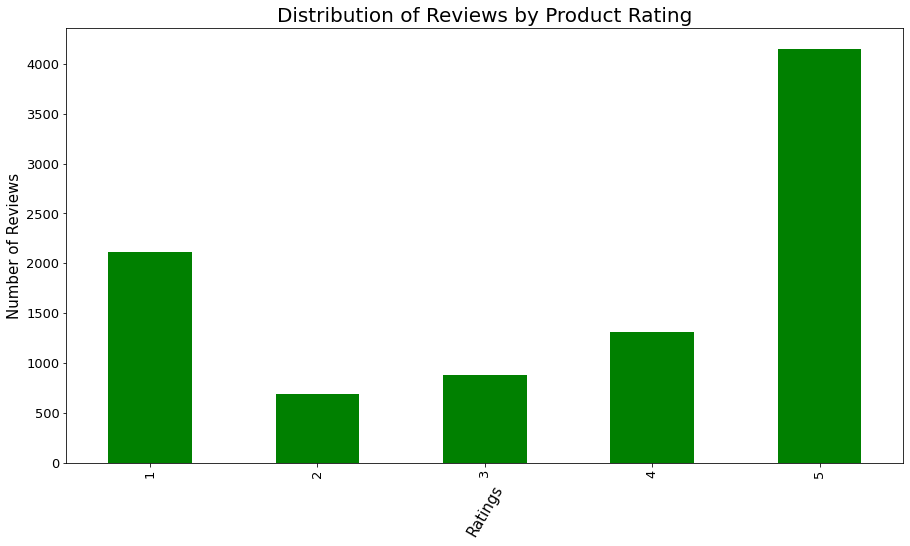

In [39]:
# plot the data
ax1 = ratings_review.plot(kind='bar', figsize=(15,8), color="green", fontsize = 13);
ax1.set_alpha(0.8)
ax1.set_title('Distribution of Reviews by Product Rating', fontsize = 20)
ax1.set_ylabel("Number of Reviews", fontsize = 15);
ax1.set_xlabel("Ratings", fontsize = 15 , rotation = 60)
plt.show();


Mobile phones with higher rating receive the highest number of reviews followed by phones with the least review rating.

### 6.3.  Brands with the most expensive phones


In [40]:
# Group relevant columns
brand_reviews = df.groupby('Brand')['Review'].count().sort_values(ascending = False).head(10)
brand_prices = df.groupby('Brand')['Price'].max().sort_values(ascending = False).head(10)

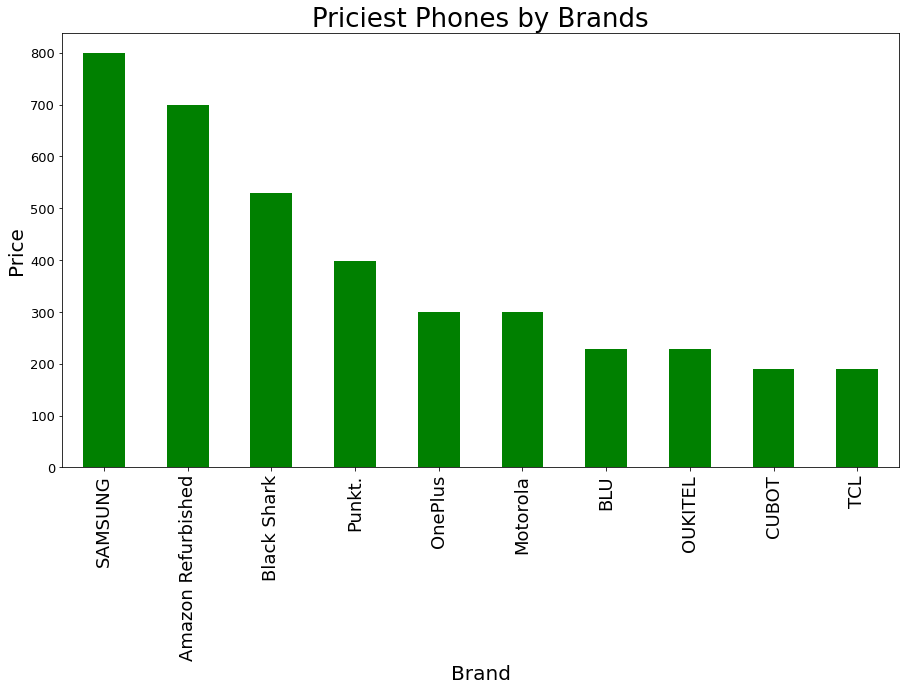

In [43]:
# Plot the graph
ax1 = brand_prices.plot(kind = 'bar', figsize = (15,8), color = 'green', fontsize = 13);
ax1.set_alpha(0.8)
ax1.set_title('Priciest Phones by Brands', fontsize = 26)
ax1.set_ylabel('Price', fontsize = 20);
ax1.set_xlabel('Brand', fontsize = 20)
plt.xticks(fontsize = 18)
plt.show();

Samsung phones have the priciest phones. Samsung is one of the top phone brands in the world and with high performance, which could explain the high prices of its models. It is however interesting that Apple/Iphones do not appear here yet they own a great market share. This will be explored further.

In [42]:
# Filter strings that contain iphone or pro max
iphone_ = df[df['Model_Type'].str.contains('iPhone| Pro MAX')] 

# Explore value counts of the new dataframe
iphone_.Model_Type.value_counts().to_frame()

,Model_Type
Apple iPhone 8,649
i12 Pro MAX,43


Most of the iphones sold on Amazon are under refurbished phones. 
Acording to [Gear Patrol](https://www.gearpatrol.com/tech/a37134997/should-you-buy-apple-devices-on-amazon/), while Amazon since 2018 became an authorised dealer, the site is flooded by third party sellers many of whom have a history of trying to pass off counterfeits as legitimate Apple products. This has greatly affected iphone sales on the site. A clear example from the data is the third party seller **Dilwe** who seems to have many reviews saying he is selling fake iphones. 

In [ ]:
# Print Dilwe reviews
dilwe_iphones = df.loc[df['Brand'] == 'Dilwe']

# Shuffle the rows
dilwe_iphones = dilwe_iphones.sample(frac = 1)

# Explore dataframe head
dilwe_iphones.head()

,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review,ratings_sentiment
1774,i12 Pro MAX,Dilwe,126,2022-02-25,1,Overall terrible!! The battery lasted maybe 45...,Everything!!!,negative
1779,i12 Pro MAX,Dilwe,126,2021-10-05,2,Not an Apple phone. Just a look alike,Description should not be deceptive like it is.,negative
1730,i12 Pro MAX,Dilwe,126,2022-06-21,1,Some things were missing upon delivery.,"I did not receive any Sim Card Tool Kit, There...",negative
1727,i12 Pro MAX,Dilwe,126,2022-09-06,1,. I feel like I've been robbed not what you w...,Terrible and not what I expected. Promise a re...,negative
1762,i12 Pro MAX,Dilwe,126,2022-02-06,1,I was cheated this phone is not a iPhone 12 an...,I was cheated not a I phone and my son was so ...,negative


### 6.4. Brands with the highest number of reviews

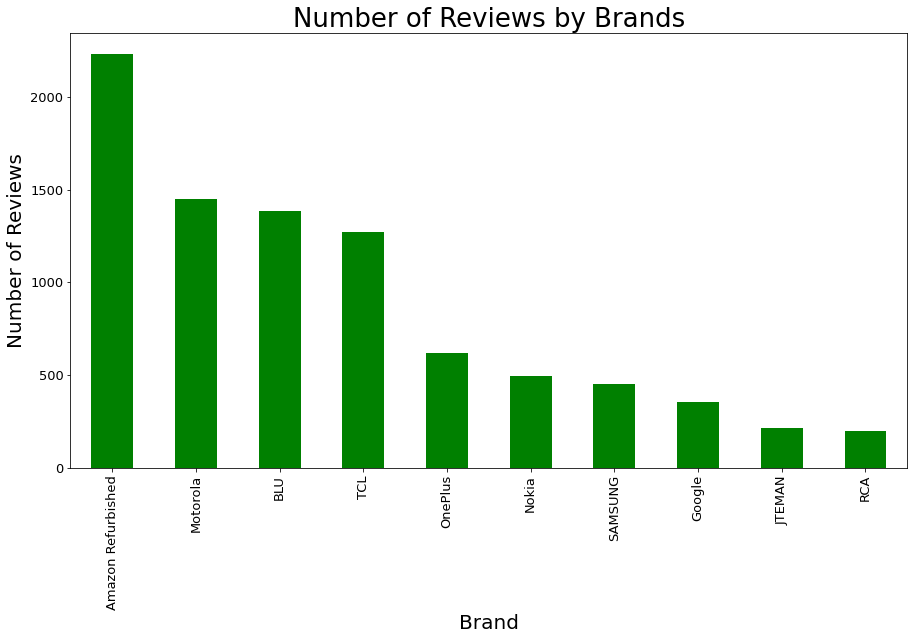

In [44]:
# Plot the data
ax2 = brand_reviews.plot(kind = 'bar', figsize = (15,8), color = 'green', fontsize = 13);
ax2.set_alpha(0.8)
ax2.set_title('Number of Reviews by Brands', fontsize = 26)
ax2.set_ylabel('Number of Reviews', fontsize = 20);
ax2.set_xlabel('Brand', fontsize = 20)
plt.show();


Refurbished phones have the highest number of reviews. Refurbished phones are ones that have gone through some form of repair and are not new. This could explain why consumers feel the need to review their performance and effectiveness.


### 6.5. Word cloud of the most-used words in reviews.

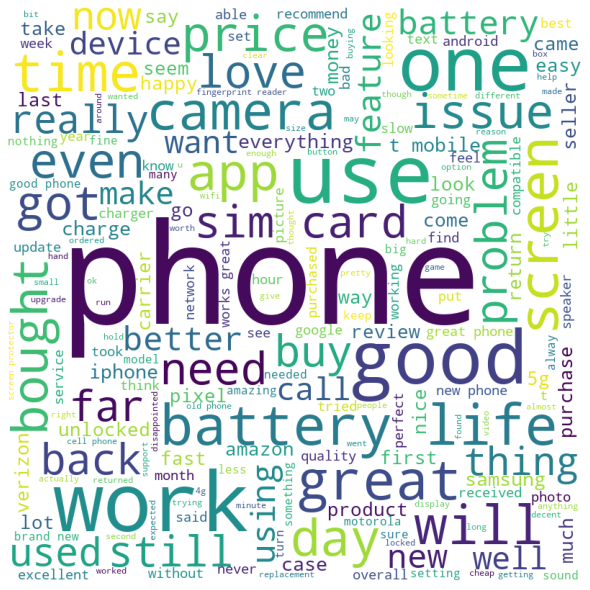

In [45]:
# Plot a word cloud 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.Review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (15, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show() 

good, great, battery price, issue and work are some of the words that pop up more in the reviews.

It is interesting that **iphone** appears in the word cloud despite having less products being sold. This will be explored further.

In [46]:
# Remove rows containing iphone as a product
iphone_frequency = df[~df['Model_Type'].str.contains('iPhone| Pro MAX')] 

# Print reviews with the word iphone
iphones_frequency = iphone_frequency[iphone_frequency['Review Title'].str.contains('iPhone | iphone')] 

# Shuffle the rows
iphones_frequency = iphones_frequency.sample(frac = 1)

# Print the shape of the new dataframe
print(iphone_frequency.shape)

# Explore dataframe head
iphones_frequency.head()

(8464, 8)


,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review,ratings_sentiment
9937,Moto G fast,Motorola,128,2020-06-20,5,iPhone quality at a 1/3 of the price!,Finally a phone I absolutely love!! I came fro...,positive
12575,TCL 20 SE,TCL,189,2021-10-25,5,Better than iphone...,2 months later n it's still performing like it...,positive
9407,OnePlus Nord N200,OnePlus,239,2022-07-17,5,iPhone Owner Pleased,Being in I.T. I think it's important to use an...,positive
2815,Moto G Power,Motorola,149,2021-06-10,5,Like this phone as good as iphone I had,"Like the phone easy to use, reasonable price, ...",positive
6847,Google Pixel 6,Google,1,2022-04-02,5,iPhone user who switched to a Google Pixel phone,I'm an iPhone convert for about 10 years.I rea...,positive


There are more that 8 thousand rows where **iphone** is mentioned in Review Title despite the product not being an iphone.

### 6.6. Trend of reviews over the years

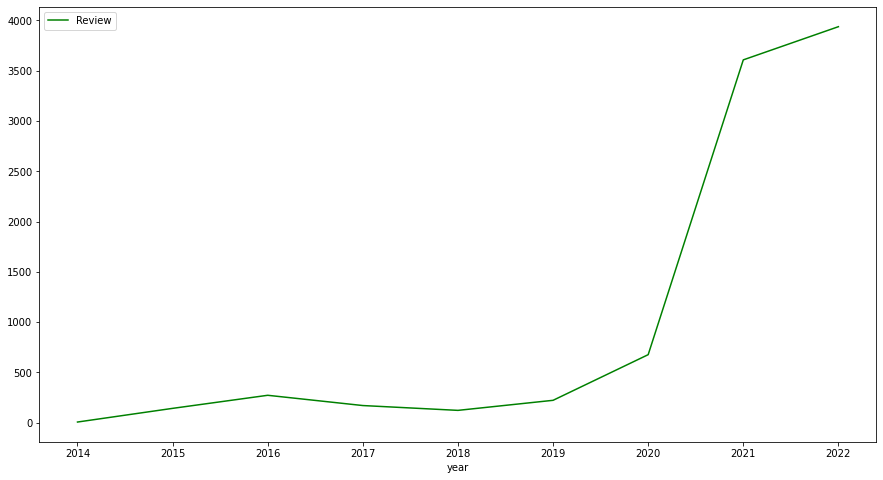

In [47]:
# Create a new dataframe to use while maintaining the original
new_df = df.copy()

# Extract year from the new dataframe
new_df['year'] = new_df['Review Date'].dt.year

# Group by relevant columns
review_date = new_df.groupby('year')['Review'].count()
review_date = pd.DataFrame(review_date).reset_index()

# plot the data
review_date.plot.line(x = 'year', y = 'Review', color = 'green', figsize=(15, 8));


The rate of customer reviews took a major increase from 2020. This could be attributed to the Covid Pandemic where people spent lots of time indoors and online shopping was at an all time high.

### 6.7. Relationship between price and Ratings

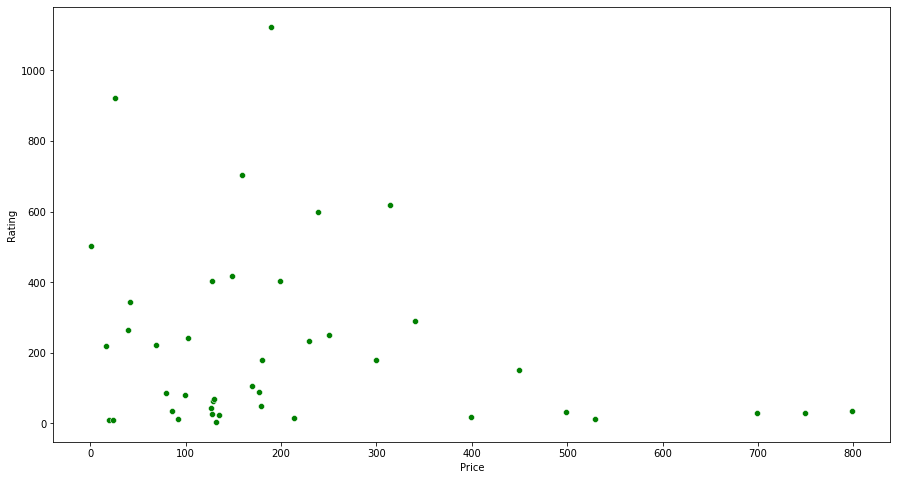

In [48]:
# Group by relevant columns
review_price = new_df.groupby('Price')['Rating'].count()
review_price = pd.DataFrame(review_price).reset_index()

# Plot the data
fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(x = 'Price', y = 'Rating', data = review_price, color = 'green')
plt.show();

The scatter plot above does not show a correlation between price and rating.

# 7. Implementing the Solution

## 7.1. Preprocessing

- tokenization
- lowercasing our words
- lemmatization/stemming
- vectorization

The first step will be to perform a contraction the reviews, to make sure that our words are expanded, for example, `isn't` would be expanded to `is not`

In [49]:
# fixing contractions
def text_contraction(text):
  
  # creating an empty list
  expanded_words = []

  for word in text.split():
    # using contractions.fix to expand the shortened words
    expanded_words.append(contractions.fix(word))  
    
  expanded_text = ' '.join(expanded_words)

  return expanded_text

In [50]:
# apply the contraction funtion to our reviews

df['Review Title'] = df['Review Title'].map(lambda x: text_contraction(x))
df['Review'] = df['Review'].map(lambda x: text_contraction(x))

In [51]:
# # grab the stop words from stopwords.words('english)
# #stopwords_list = stopwords.words('english')
# #stopwords_list += punctuation
# from nltk.corpus import stopwords
# stopwords_list = stopwords.words('english') + list(string.punctuation)
# stopwords_list += ["''", '""', '...', '``']

# # remove the stop words
# clean_list = [word.lower() for word in tokens if word.lower() not in stopwords_list]


In [52]:
# tokenization

def tokenize_words(text):
  # grab all the punctuations
  punctuation = string.punctuation

  # lower case our string
  # text = str([word.lower() for word in t
  # remove the digits
  text = re.sub('\d', '', text)

  # cretae our word tokens
  tokens = word_tokenize(text)

  # grab the stop words from stopwords.words('english)
  # stopwords_list = stopwords.words('english')
  # stopwords_list += punctuation
  # stopwords_list = stopwords.words('english') + list(string.punctuation)
  # stopwords_list += ["''", '""', '...', '``', '..', '....']
  punctuation_list = list(string.punctuation)
  punctuation_list += ["''", '""', '...', '``', '..', '....']

  # remove the stop words
  clean_list = [word.lower() for word in tokens if word.lower() not in punctuation_list]
  
  # return a clean tokenized set
  return clean_list

In [55]:
df['Review'] = df['Review'].map(lambda x: tokenize_words(x))
df['Review Title'] = df['Review Title'].map(lambda x: tokenize_words(x))

After tokenization, lemmatization is done to decompose the words to their most basic forms(lemma), but before that, tagging the words is done to ensure that the lemmatization gets the parts of speech represented by the words correctly.

In [56]:
# create a function that takes in the nltk POS tags
# and transforms them to wordnet tags
def wordnet_pos(word_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if word_tag.startswith('J'):
        return wordnet.ADJ
    elif word_tag.startswith('V'):
        return wordnet.VERB
    elif word_tag.startswith('N'):
        return wordnet.NOUN
    elif word_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [59]:
# check to see the part of speech tags for the first review
sentence = df["Review"][0]
pos_tag(sentence[0:4])

[('so', 'RB'), ('first', 'RB'), ('off', 'IN'), ('it', 'PRP')]

In [60]:
# inastantiate the lemmatizer
lemmatizer = WordNetLemmatizer() 

In [61]:
df['Review'][0:2]

0    [so, first, off, it, is, not, what, i, ordered...
2    [new, phone, write, up, indicates, t-mobile, s...
Name: Review, dtype: object

In [62]:
def word_lemma(text):
    '''
    Translate the text POS tags to Word net tags then pass it to the lemmatizer
    
    '''
    # get the pos tags for the text
    word_pos_tags = pos_tag(text)
    
    # translate the pos tags to word net tags
    word_net_tag = [(text[0], wordnet_pos(text[1])) for text in word_pos_tags]
    
    # Pass the text with the wordnet tags to the lemmatizer
    lemma_word = [lemmatizer.lemmatize(text[0], text[1]) for text in word_net_tag]
    
    return lemma_word
    

In [67]:
# map the word lemma function on the review and review_title column
df['Review'] = df['Review'].apply(word_lemma)
df['Review Title'] = df['Review Title'].apply(word_lemma)
df.head(2)

,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review,ratings_sentiment
0,RCA Reno,RCA,69,2022-02-11,4,"[not, what, order, not, new, but, it, work, so...","[so, first, off, it, be, not, what, i, order, ...",positive
2,RCA Reno,RCA,69,2022-06-07,3,"[will, not, work, on, t-mobile, sysem]","[new, phone, write, up, indicate, t-mobile, sy...",neutral


### 7.1.1. Frequency Distribution Plot

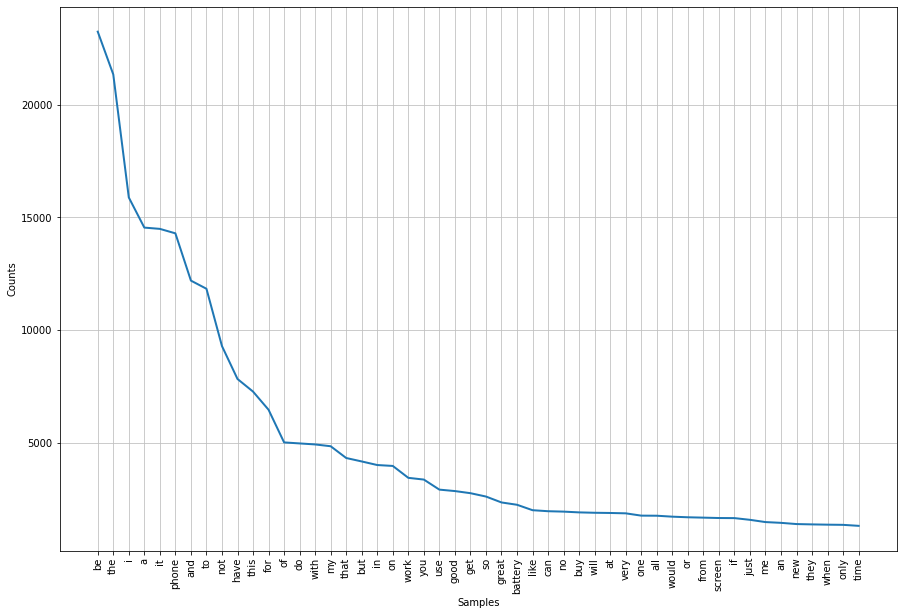

In [68]:
# create the frequency distribution plot
sample = df['Review']
freq1_dist = []

for review in sample:
    freq1_dist.extend(review)
    
fdist = FreqDist(freq1_dist)
plt.figure(figsize=(15, 10))
fdist.plot(50);

In [69]:
# display the count of the first 200 texts
word_frequency = fdist.most_common(200)
word_frequency[:5]

[('be', 23242), ('the', 21344), ('i', 15885), ('a', 14548), ('it', 14491)]

In [70]:
# convert the list into a string

X = df['Review']

df["Review"]= X.map(lambda x: ' '.join(map(str, x)))

## 7.2. Modeling

### 7.2.1. Vader Analysis

In [ ]:
df["id"] = df.index + 1
df = df.reindex(columns=['id', 'Model_Type', 'Brand', 'Price', 'Review Date', 
                         'Rating', 'Review Title', 'Review', 'ratings_sentiment'])
df.drop("Review Date", axis=1, inplace=True)


In [ ]:
# creating polarity scores on the entire dataset

sia = SentimentIntensityAnalyzer()
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row["Review"]
  id = row["id"]
  res[id] = sia.polarity_scores(text)


  0%|          | 0/9156 [00:00<?, ?it/s]

In [ ]:
# populating results into a df
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns={"index":"id"})
vader_df = vader.merge(df, how="left")

In [ ]:
# sentiment scores combined with the meta data
# pd.set_option('display.max_colwidth',10000)
vader_df.head(3)

,id,neg,neu,pos,compound,Model_Type,Brand,Price,Rating,Review Title,Review,ratings_sentiment
0,1,0.103,0.806,0.091,-0.6901,RCA Reno,RCA,69,4,"[not, what, order, not, new, but, it, work, so...",so first off it be not what i order but i do n...,positive
1,3,0.058,0.921,0.021,-0.6480,RCA Reno,RCA,69,3,"[will, not, work, on, t-mobile, sysem]",new phone write up indicate t-mobile system co...,neutral
2,4,0.055,0.748,0.197,0.9585,RCA Reno,RCA,69,3,"[a, burner, or, for, a, kid]",i use this a a burner w/o a sim card in it jus...,neutral


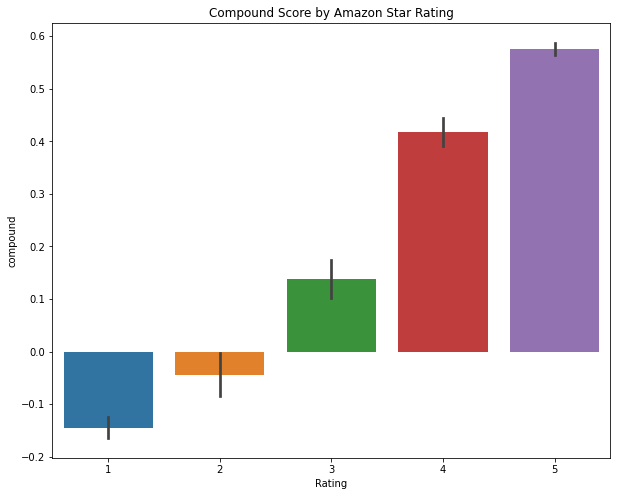

In [ ]:
# plotting a bar plot to compare rating and compound value to see if the ratings align with the sentiment scores
df_sorted = vader_df.sort_values('Rating')
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df_sorted, x = "Rating", y="compound")
ax.set_title("Compound Score by Amazon Star Rating")
plt.show()

Making assumptions on our data, if rating is 5, then it is likely to be a more positive value than a rating of 1.

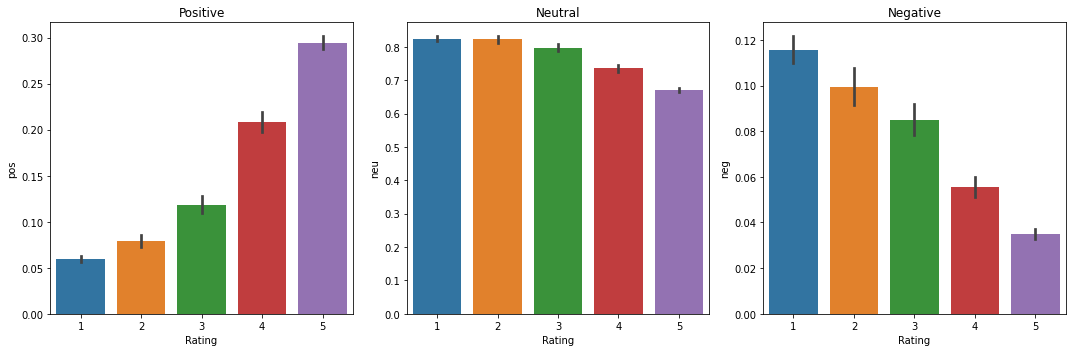

In [ ]:
# Plot the distrubution of sentiments across different ratings
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=df_sorted, x = "Rating", y="pos", ax=axs[0])
sns.barplot(data=df_sorted, x = "Rating", y="neu", ax=axs[1])
sns.barplot(data=df_sorted, x = "Rating", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

The more positive the compound value, the higher the Ranking score. Positive values represent high rankings of 4 and 5 while low rankings of 1 and 2 mainly show negative values. This proves the assumption made on the data.

In [ ]:
# splitting data 

# df_train, df_test = train_test_split(
#   df,
#   test_size=0.3,
#   random_state=23
# )
# df_val, df_test = train_test_split(
#   df_test,
#   test_size=0.5,
#   random_state=23
# )

In [ ]:
y = df['ratings_sentiment']
X = df.drop('ratings_sentiment', axis=1)

In [ ]:
# Exploring vader as a model for sentiment analysis

analyzer = SentimentIntensityAnalyzer()

In [ ]:
X["scores"] = X["Review"].apply(lambda review : analyzer.polarity_scores(review))
X["compound"] = X["scores"].apply(lambda score_dict :score_dict["compound"])
X["vader_label"] = X["compound"].apply(lambda c : "positive" if c >= 0.05 else "negative" if c <= -0.05 else "neutral")


In [ ]:
# Exploring the unique elements in label column
X["vader_label"].value_counts().to_frame()

,vader_label
positive,5750
negative,2210
neutral,1196


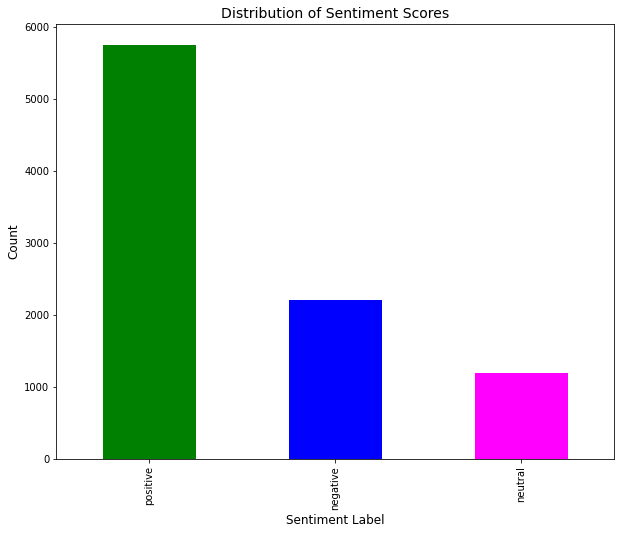

In [ ]:
# plotting distribution of sentiment scores
colors = ['green', 'blue', 'magenta']
X["vader_label"].value_counts().plot(kind="bar", color = colors, figsize=(10, 8))
plt.xlabel("Sentiment Label", size=12)
plt.ylabel("Count", size=12)
plt.title("Distribution of Sentiment Scores", size=14);

In [ ]:
print(classification_report(y, X['vader_label']))

              precision    recall  f1-score   support

    negative       0.65      0.51      0.57      2806
     neutral       0.10      0.13      0.11       883
    positive       0.78      0.82      0.80      5467

    accuracy                           0.66      9156
   macro avg       0.51      0.49      0.49      9156
weighted avg       0.67      0.66      0.66      9156



### 7.2.2. Text Blob

In [ ]:
# Implementing the textblob analysis

X[["polarity", "subjectivity"]] = X["Review"].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [ ]:
# exploring the positive comments

X[X.polarity > 0].tail(3)

,id,Model_Type,Brand,Price,Rating,Review Title,Review,scores,compound,vader_label,polarity,subjectivity
17164,17165,BLU F91 5G,BLU,229,5,"[great, phone]",i be not super tech savvy i just want a reliab...,"{'neg': 0.041, 'neu': 0.753, 'pos': 0.206, 'co...",0.9933,positive,0.262195,0.568817
17165,17166,BLU F91 5G,BLU,229,5,"[good, deal]",good deal,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404,positive,0.700000,0.600000
17167,17168,BLU F91 5G,BLU,229,5,"[eat, your, heart, out, apple, samsung]",whoa my first blu phone and i be never buy ano...,"{'neg': 0.028, 'neu': 0.681, 'pos': 0.292, 'co...",0.9849,positive,0.286111,0.455000


In [ ]:
# exploring the negative comments

# df[df.polarity < 0].head()

In [ ]:
# exploring neutral comments

# df[df.polarity == 0].head()

In [ ]:
X["Text_blob_labels"] = X["polarity"].apply(lambda c : "positive" if c > 0 else "negative" if c < 0 else "neutral")

In [ ]:
X.head(3)

,id,Model_Type,Brand,Price,Rating,Review Title,Review,scores,compound,vader_label,polarity,subjectivity,Text_blob_labels
0,1,RCA Reno,RCA,69,4,"[not, what, order, not, new, but, it, work, so...",so first off it be not what i order but i do n...,"{'neg': 0.103, 'neu': 0.806, 'pos': 0.091, 'co...",-0.6901,negative,0.012251,0.506010,positive
2,3,RCA Reno,RCA,69,3,"[will, not, work, on, t-mobile, sysem]",new phone write up indicate t-mobile system co...,"{'neg': 0.058, 'neu': 0.921, 'pos': 0.021, 'co...",-0.6480,negative,-0.070455,0.277652,negative
3,4,RCA Reno,RCA,69,3,"[a, burner, or, for, a, kid]",i use this a a burner w/o a sim card in it jus...,"{'neg': 0.055, 'neu': 0.748, 'pos': 0.197, 'co...",0.9585,positive,0.161616,0.497475,positive


In [ ]:
print(classification_report(y, X["Text_blob_labels"]))

              precision    recall  f1-score   support

    negative       0.71      0.39      0.50      2806
     neutral       0.09      0.14      0.11       883
    positive       0.73      0.84      0.78      5467

    accuracy                           0.63      9156
   macro avg       0.51      0.45      0.46      9156
weighted avg       0.66      0.63      0.63      9156



### 7.2.3. Roberta Model: Neural Network Model

In [ ]:
# # transfer learning on a pretrained model
# # finding pretrained weights to use in the model
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
data["id"] = data.index + 1
data = data.reindex(columns=['id', 'Model_Type', 'Brand', 'Price', 'Review Date', 
                         'Rating', 'Review Title', 'Review', 'ratings_sentiment'])
data.head(3)

,id,Model_Type,Brand,Price,Review Date,Rating,Review Title,Review,ratings_sentiment
0,1,RCA Reno,RCA,69,2022-02-11,4,".. not what ordered, not New... but it works s...","So first off...it's not what I ordered, but I ...",positive
2,3,RCA Reno,RCA,69,2022-06-07,3,Will not work on T-Mobile sysem!,New phone write up indicates T-Mobile system c...,neutral
3,4,RCA Reno,RCA,69,2022-04-14,3,A burner or for a kid,I use this as a burner w/o a sim card in it. J...,neutral


In [ ]:
def polarity_scores_roberta(words):
  encoded_text = tokenizer(words, return_tensors="pt")
  output = model(**encoded_text)
  scores = output [0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict ={
      "roberta_neg": scores[0],
      "roberta_neu" : scores[1],
      "roberta_pos" : scores [2]
  }
  return scores_dict


In [ ]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
  try:
    text = row["Review"]
    id = row["id"]
    roberta_results = polarity_scores_roberta(text)
  except RuntimeError:
    print(f'Broke for id {id}')

  0%|          | 0/9156 [00:00<?, ?it/s]

Broke for id 1
Broke for id 76
Broke for id 87
Broke for id 547
Broke for id 1938
Broke for id 2374
Broke for id 2552


KeyboardInterrupt: ignored

In [ ]:
vader = pd.DataFrame(res).T
# vader = vader.reset_index().rename(columns={"index":"id"})
# vader_df = vader.merge(df, how="left")

# 8. Challenging the Solution

### 8.1. Bert Model

# 9. Conclusions

# 10. Recommendations